In [1]:
# ================= IMPORTS =================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
)

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb


In [2]:
# ================= LOAD & PREPROCESS =================
cols = ["ID", "Diagnosis"] + [f"feature_{i}" for i in range(1, 31)]
df = pd.read_csv("wdbc.data", header=None, names=cols)

# Drop ID column
df.drop(columns=["ID"], inplace=True)

# Encode labels (M=1, B=0)
df["Diagnosis"] = LabelEncoder().fit_transform(df["Diagnosis"])

# Features / Target
X_raw = df.drop(columns=["Diagnosis"])
y = df["Diagnosis"]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


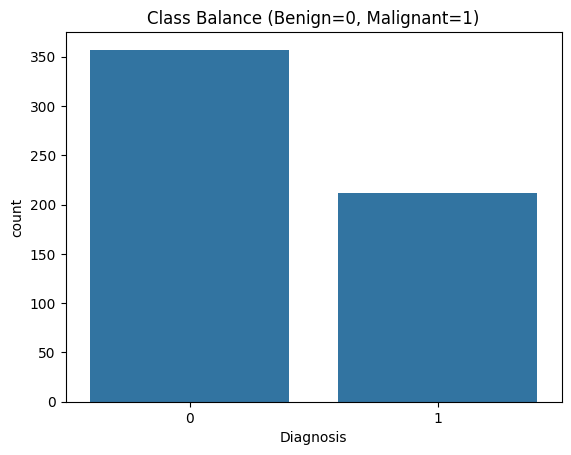

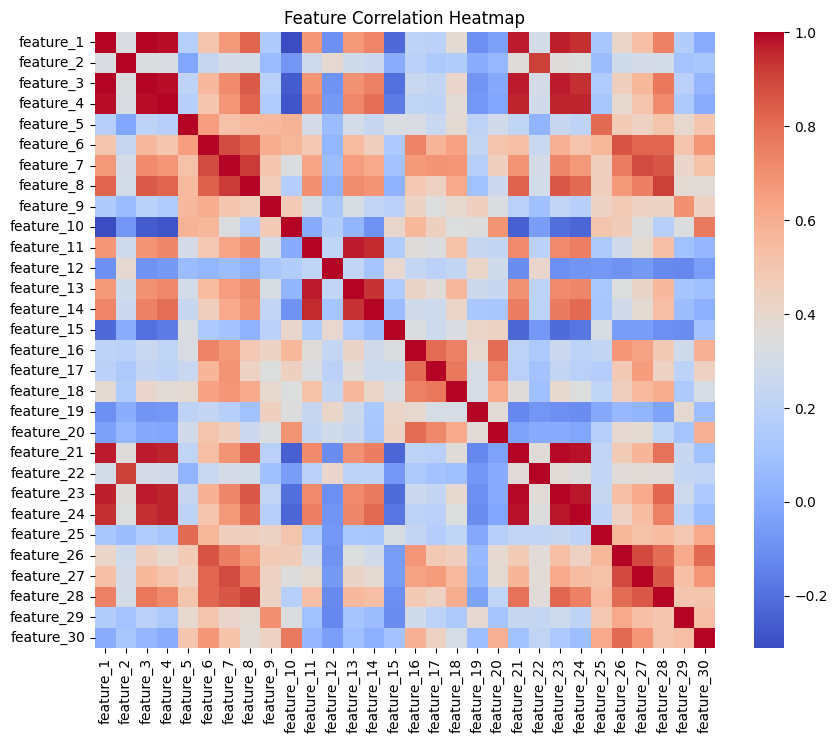

In [3]:
# ================= EDA =================
sns.countplot(x=y)
plt.title("Class Balance (Benign=0, Malignant=1)")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(columns=["Diagnosis"]).corr(), cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


In [4]:
# ================= EVALUATION FUNCTION =================
def evaluate(name, model, X_test, y_test):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"{name} Performance", fontsize=16)

    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, probs)
        roc_auc = auc(fpr, tpr)

        ax1.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
        ax1.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        ax1.set_xlim([0.0, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel("False Positive Rate")
        ax1.set_ylabel("True Positive Rate")
        ax1.set_title("ROC Curve")
        ax1.legend(loc="lower right")

    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax2, cmap=plt.cm.Reds)
    ax2.set_title("Confusion Matrix")

    plt.tight_layout()
    plt.show()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{name}")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 Score:", f1)

    return acc, prec, rec, f1


In [5]:
# ================= HYPERPARAMETER SPACES =================
models_params = {
    "Decision Tree": (
        DecisionTreeClassifier(random_state=42),
        {"criterion": ["gini", "entropy"], "max_depth": [3, 5, 10, None]}
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=42),
        {"n_estimators": [50, 100, 200], "max_depth": [3, 5, 10, None], "criterion": ["gini", "entropy"]}
    ),
    "AdaBoost": (
        AdaBoostClassifier(random_state=42, estimator=DecisionTreeClassifier(random_state=42)),
        {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 1], "estimator__max_depth": [1, 3, 5]}
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=42),
        {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.5], "max_depth": [3, 5, 7]}
    ),
    "XGBoost": (
        xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.3], "max_depth": [3, 5, 7], "gamma": [0, 0.1, 0.3]}
    ),
}

results_table = []
trial_tables = {}
best_estimators = {}



--- Grid Search for Decision Tree ---
Best Params: {'criterion': 'entropy', 'max_depth': 10}
Best CV Score: 0.9362637362637362


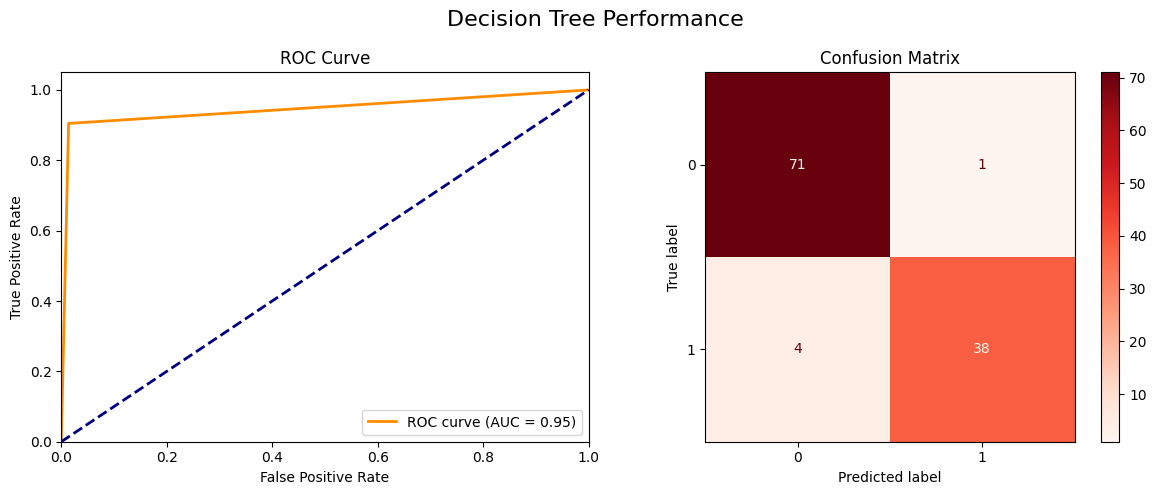


Decision Tree
Accuracy: 0.956140350877193
Precision: 0.9743589743589743
Recall: 0.9047619047619048
F1 Score: 0.9382716049382716

Top 5 Hyperparameter Trials for Decision Tree
  criterion  max_depth  CV Accuracy  F1 Score (Test)
6   entropy       10.0     0.936264         0.938272
7   entropy        NaN     0.936264         0.938272
1      gini        5.0     0.934066         0.938272
5   entropy        5.0     0.934066         0.938272
0      gini        3.0     0.931868         0.938272

--- Grid Search for Random Forest ---
Best Params: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50}
Best CV Score: 0.9670329670329672


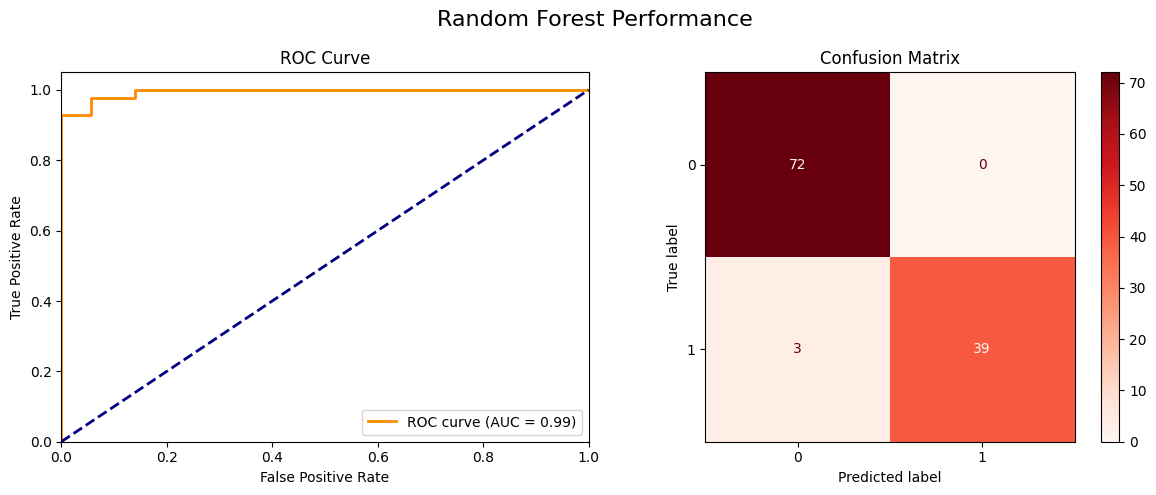


Random Forest
Accuracy: 0.9736842105263158
Precision: 1.0
Recall: 0.9285714285714286
F1 Score: 0.9629629629629629

Top 5 Hyperparameter Trials for Random Forest
   criterion  max_depth  n_estimators  CV Accuracy  F1 Score (Test)
6       gini       10.0            50     0.967033         0.962963
9       gini        NaN            50     0.967033         0.962963
21   entropy        NaN            50     0.962637         0.962963
7       gini       10.0           100     0.962637         0.962963
18   entropy       10.0            50     0.962637         0.962963

--- Grid Search for AdaBoost ---
Best Params: {'estimator__max_depth': 3, 'learning_rate': 1, 'n_estimators': 50}
Best CV Score: 0.9692307692307693


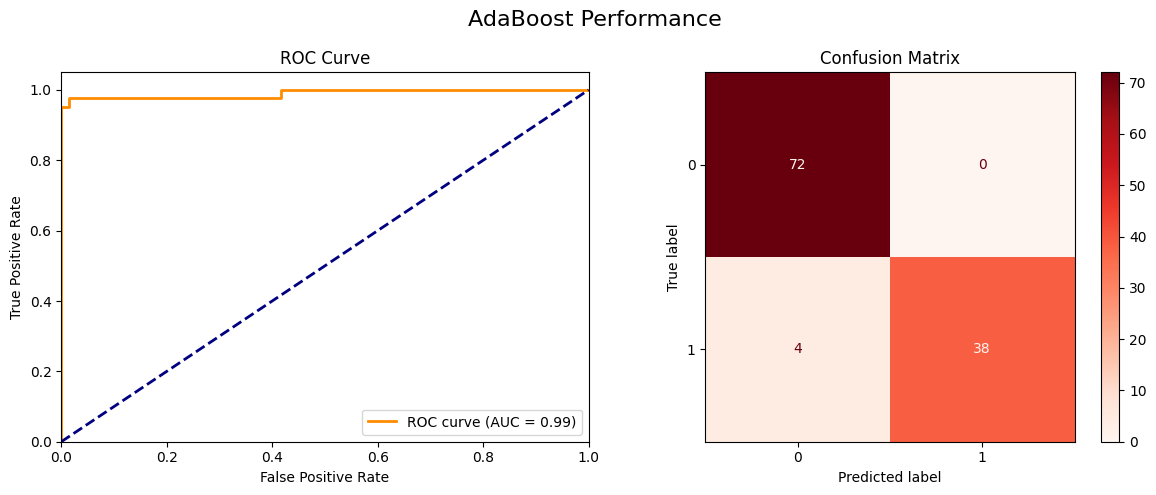


AdaBoost
Accuracy: 0.9649122807017544
Precision: 1.0
Recall: 0.9047619047619048
F1 Score: 0.95

Top 5 Hyperparameter Trials for AdaBoost
    estimator__max_depth  learning_rate  n_estimators  CV Accuracy  \
15                     3            1.0            50     0.969231   
13                     3            0.1           100     0.967033   
8                      1            1.0           200     0.964835   
17                     3            1.0           200     0.962637   
16                     3            1.0           100     0.962637   

    F1 Score (Test)  
15             0.95  
13             0.95  
8              0.95  
17             0.95  
16             0.95  

--- Grid Search for Gradient Boosting ---
Best Params: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100}
Best CV Score: 0.9582417582417584


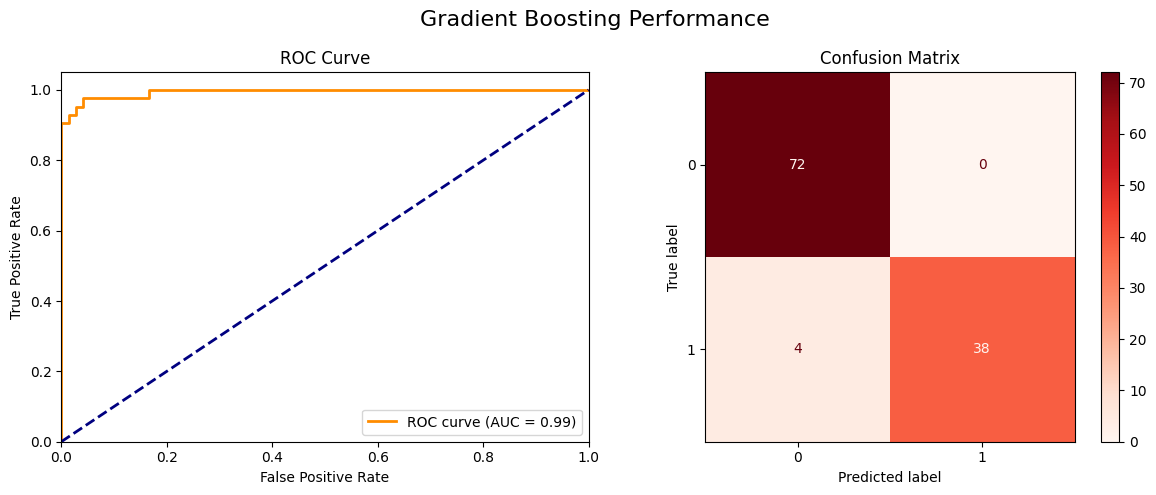


Gradient Boosting
Accuracy: 0.9649122807017544
Precision: 1.0
Recall: 0.9047619047619048
F1 Score: 0.95

Top 5 Hyperparameter Trials for Gradient Boosting
    learning_rate  max_depth  n_estimators  CV Accuracy  F1 Score (Test)
20            0.5          3           200     0.958242             0.95
19            0.5          3           100     0.958242             0.95
9             0.1          3            50     0.956044             0.95
18            0.5          3            50     0.953846             0.95
11            0.1          3           200     0.953846             0.95

--- Grid Search for XGBoost ---
Best Params: {'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200}
Best CV Score: 0.9714285714285715


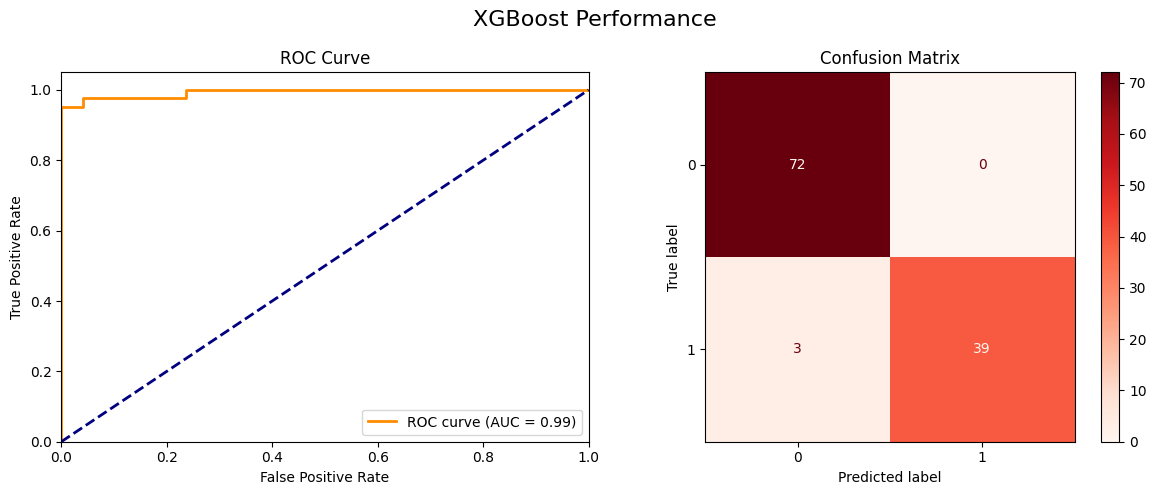


XGBoost
Accuracy: 0.9736842105263158
Precision: 1.0
Recall: 0.9285714285714286
F1 Score: 0.9629629629629629

Top 5 Hyperparameter Trials for XGBoost
    gamma  learning_rate  max_depth  n_estimators  CV Accuracy  \
20    0.0            0.3          3           200     0.971429   
18    0.0            0.3          3            50     0.969231   
19    0.0            0.3          3           100     0.969231   
25    0.0            0.3          7           100     0.967033   
26    0.0            0.3          7           200     0.967033   

    F1 Score (Test)  
20         0.962963  
18         0.962963  
19         0.962963  
25         0.962963  
26         0.962963  


In [6]:
# ================= GRIDSEARCH + TRIAL TABLE =================
for name, (model, params) in models_params.items():
    print(f"\n--- Grid Search for {name} ---")
    grid = GridSearchCV(model, params, cv=5, scoring="accuracy", n_jobs=-1, return_train_score=False)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    best_estimators[name] = best_model
    print("Best Params:", grid.best_params_)
    print("Best CV Score:", grid.best_score_)

    # Evaluate
    start = time.time()
    best_model.fit(X_train, y_train)
    elapsed = time.time() - start
    res = evaluate(name, best_model, X_test, y_test)
    results_table.append((name, grid.best_params_, *res, elapsed))

    # Collect top 5 hyperparameter trials
    trial_res = []
    for i in range(len(grid.cv_results_["params"])):
        trial_res.append({
            **grid.cv_results_["params"][i],
            "CV Accuracy": grid.cv_results_["mean_test_score"][i]
        })
    trial_df = pd.DataFrame(trial_res).sort_values(by="CV Accuracy", ascending=False).head(5)

    y_pred = best_model.predict(X_test)
    trial_df["F1 Score (Test)"] = f1_score(y_test, y_pred)

    trial_tables[name] = trial_df

    print(f"\nTop 5 Hyperparameter Trials for {name}")
    print(trial_df)


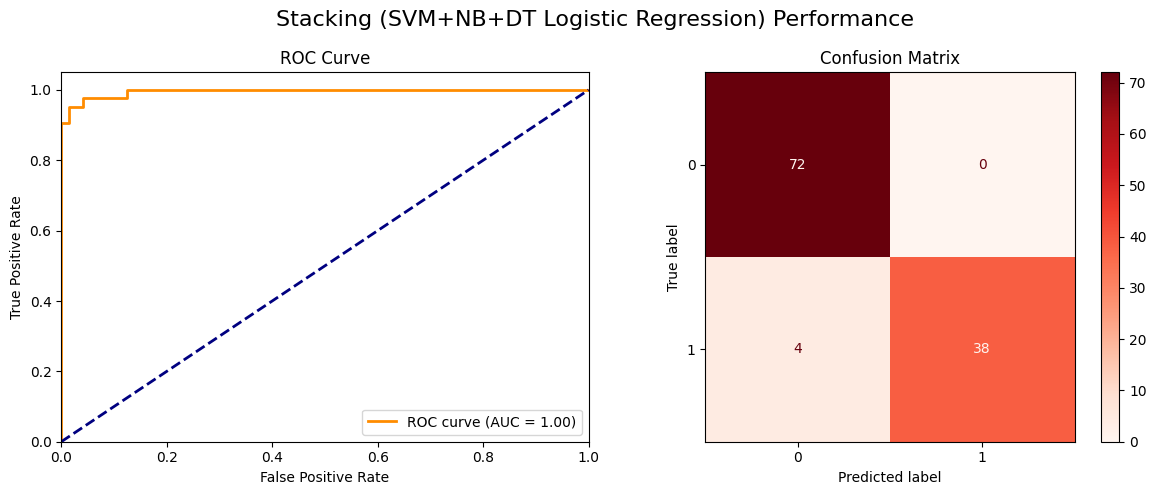


Stacking (SVM+NB+DT Logistic Regression)
Accuracy: 0.9649122807017544
Precision: 1.0
Recall: 0.9047619047619048
F1 Score: 0.95


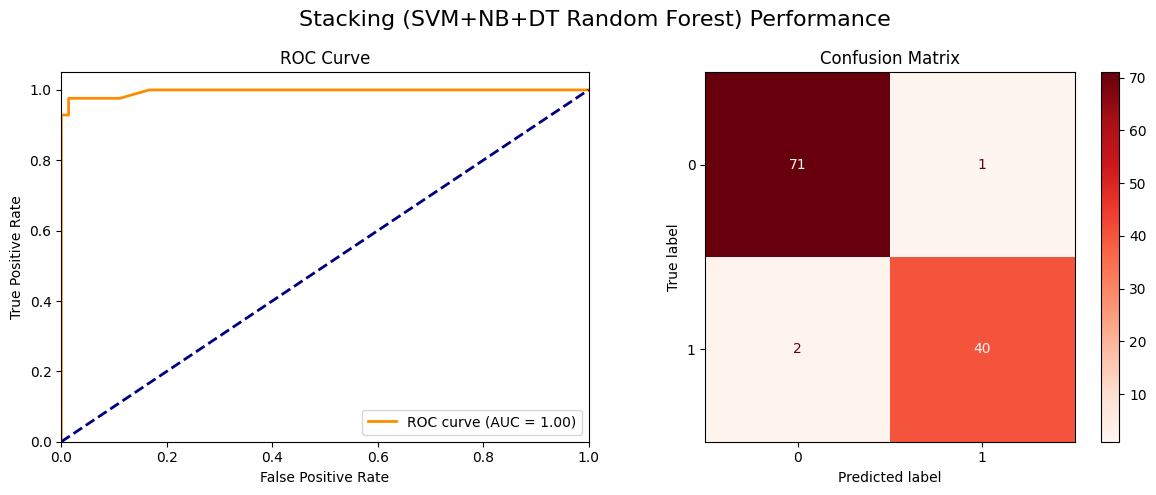


Stacking (SVM+NB+DT Random Forest)
Accuracy: 0.9736842105263158
Precision: 0.975609756097561
Recall: 0.9523809523809523
F1 Score: 0.963855421686747


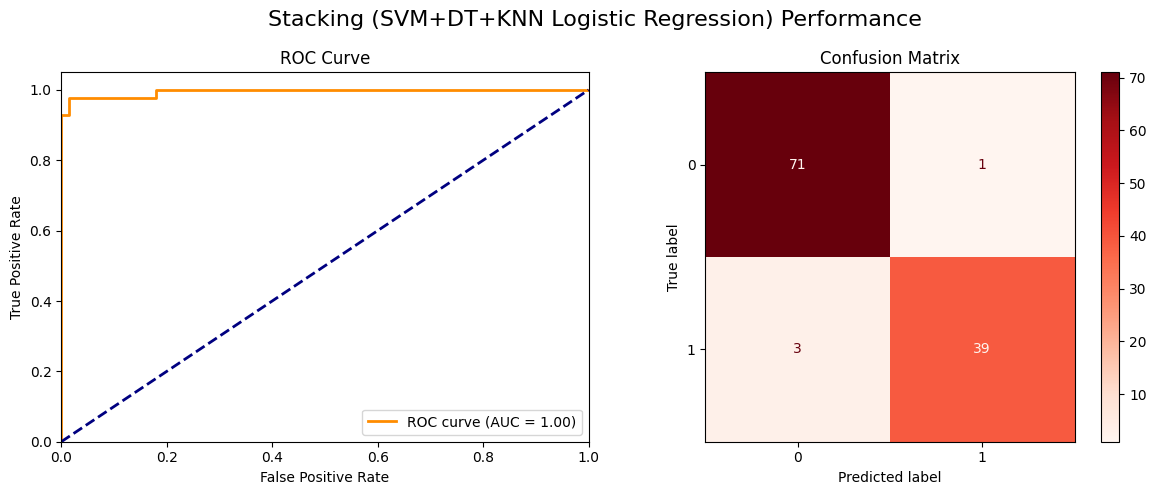


Stacking (SVM+DT+KNN Logistic Regression)
Accuracy: 0.9649122807017544
Precision: 0.975
Recall: 0.9285714285714286
F1 Score: 0.9512195121951219


In [7]:
# ================= STACKING CLASSIFIER (3 Variants) =================
stacking_variants = {
    "Stacking (SVM+NB+DT Logistic Regression)": StackingClassifier(
        estimators=[
            ("svm", SVC(probability=True, kernel="rbf", C=1, gamma="scale")),
            ("nb", GaussianNB()),
            ("dt", DecisionTreeClassifier(max_depth=5, random_state=42))
        ],
        final_estimator=LogisticRegression(max_iter=500, random_state=42)
    ),
    "Stacking (SVM+NB+DT Random Forest)": StackingClassifier(
        estimators=[
            ("svm", SVC(probability=True, kernel="rbf", C=1, gamma="scale")),
            ("nb", GaussianNB()),
            ("dt", DecisionTreeClassifier(max_depth=5, random_state=42))
        ],
        final_estimator=RandomForestClassifier(n_estimators=100, random_state=42)
    ),
    "Stacking (SVM+DT+KNN Logistic Regression)": StackingClassifier(
        estimators=[
            ("svm", SVC(probability=True, kernel="rbf", C=1, gamma="scale")),
            ("dt", DecisionTreeClassifier(max_depth=5, random_state=42)),
            ("knn", KNeighborsClassifier(n_neighbors=5))
        ],
        final_estimator=LogisticRegression(max_iter=500, random_state=42)
    ),
}

for name, stack_model in stacking_variants.items():
    start = time.time()
    stack_model.fit(X_train, y_train)
    elapsed = time.time() - start
    res = evaluate(name, stack_model, X_test, y_test)
    results_table.append((name, "Default (base learners tuned separately)", *res, elapsed))
    best_estimators[name] = stack_model


In [8]:
# ================= K-FOLD CROSS VALIDATION =================
print("\n--- 5-Fold Cross-Validation ---")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model in best_estimators.items():
    scores = cross_val_score(model, X_scaled, y, cv=kf, scoring="accuracy")
    cv_results[name] = scores
    print(f"{name} Fold Accuracies: {scores}")
    print(f"{name} Avg Accuracy: {np.mean(scores):.4f}")



--- 5-Fold Cross-Validation ---
Decision Tree Fold Accuracies: [0.94736842 0.95614035 0.9122807  0.94736842 0.95575221]
Decision Tree Avg Accuracy: 0.9438
Random Forest Fold Accuracies: [0.95614035 0.96491228 0.93859649 0.95614035 0.96460177]
Random Forest Avg Accuracy: 0.9561
AdaBoost Fold Accuracies: [0.96491228 0.97368421 0.95614035 0.99122807 0.94690265]
AdaBoost Avg Accuracy: 0.9666
Gradient Boosting Fold Accuracies: [0.96491228 1.         0.94736842 0.99122807 0.9380531 ]
Gradient Boosting Avg Accuracy: 0.9683
XGBoost Fold Accuracies: [0.95614035 0.96491228 0.95614035 0.97368421 0.96460177]
XGBoost Avg Accuracy: 0.9631
Stacking (SVM+NB+DT Logistic Regression) Fold Accuracies: [0.96491228 0.99122807 0.96491228 0.98245614 0.98230088]
Stacking (SVM+NB+DT Logistic Regression) Avg Accuracy: 0.9772
Stacking (SVM+NB+DT Random Forest) Fold Accuracies: [0.96491228 0.99122807 0.96491228 0.95614035 0.96460177]
Stacking (SVM+NB+DT Random Forest) Avg Accuracy: 0.9684
Stacking (SVM+DT+KNN Log